In [ ]:
# https://medium.com/fullstackai/how-to-train-an-object-detector-with-your-own-coco-dataset-in-pytorch-319e7090da5

In [27]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from skimage import transform
from tensorflow import keras
import numpy as np

In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [14]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]["file_name"]
        # open the input image
        img = Image.open(os.path.join(self.root, path)).convert("RGB")
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]["bbox"][0]
            ymin = coco_annotation[i]["bbox"][1]
            xmax = xmin + coco_annotation[i]["bbox"][2]
            ymax = ymin + coco_annotation[i]["bbox"][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]["area"])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)


In [15]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)


# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [16]:
# path to your own data and coco file
train_data_dir = "train/images"
train_coco = "trainval.json"

# Batch size
train_batch_size = 1

# Params for dataloader
train_shuffle_dl = True

In [17]:
print("Torch version:", torch.__version__)

# create own Dataset
my_dataset = myOwnDataset(
    root=train_data_dir, annotation=train_coco, transforms=get_transform()
)

# own DataLoader
data_loader = torch.utils.data.DataLoader(
    my_dataset,
    batch_size=train_batch_size,
    shuffle=train_shuffle_dl,
    collate_fn=collate_fn,
)

Torch version: 1.11.0
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [18]:
# Two classes; Only target class or background
num_classes = 2
num_epochs = 10

lr = 0.005
momentum = 0.9
weight_decay = 0.005

In [19]:
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=lr, momentum=momentum, weight_decay=weight_decay
)

len_dataloader = len(data_loader)

# Training
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}/{num_epochs}")
    model.train()
    i = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f"Iteration: {i}/{len_dataloader}, Loss: {losses}")

Epoch: 0/10
Iteration: 1/83, Loss: 1.4014627933502197
Iteration: 2/83, Loss: 1.2784926891326904
Iteration: 3/83, Loss: 1.0849473476409912
Iteration: 4/83, Loss: 0.9485701322555542
Iteration: 5/83, Loss: 0.7799261212348938
Iteration: 6/83, Loss: 0.726665198802948
Iteration: 7/83, Loss: 0.5404148101806641
Iteration: 8/83, Loss: 0.4366650879383087
Iteration: 9/83, Loss: 0.2722049057483673
Iteration: 10/83, Loss: 0.2992016673088074
Iteration: 11/83, Loss: 0.3589601516723633
Iteration: 12/83, Loss: 0.34054186940193176
Iteration: 13/83, Loss: 0.12270193547010422
Iteration: 14/83, Loss: 0.3663867712020874
Iteration: 15/83, Loss: 0.34606361389160156
Iteration: 16/83, Loss: 0.2282058298587799
Iteration: 17/83, Loss: 0.21722307801246643
Iteration: 18/83, Loss: 0.1210528016090393
Iteration: 19/83, Loss: 0.20119723677635193
Iteration: 20/83, Loss: 0.12101758271455765
Iteration: 21/83, Loss: 0.6285033822059631
Iteration: 22/83, Loss: 0.19095823168754578
Iteration: 23/83, Loss: 0.14131440222263336
I

Iteration: 23/83, Loss: 0.5021354556083679
Iteration: 24/83, Loss: 0.3636358082294464
Iteration: 25/83, Loss: 0.25610044598579407
Iteration: 26/83, Loss: 0.22014056146144867
Iteration: 27/83, Loss: 0.1320345550775528
Iteration: 28/83, Loss: 0.16776597499847412
Iteration: 29/83, Loss: 0.2731201648712158
Iteration: 30/83, Loss: 0.25134992599487305
Iteration: 31/83, Loss: 0.15763196349143982
Iteration: 32/83, Loss: 0.3779141902923584
Iteration: 33/83, Loss: 0.23546306788921356
Iteration: 34/83, Loss: 0.3541697859764099
Iteration: 35/83, Loss: 0.10349263995885849
Iteration: 36/83, Loss: 0.12613390386104584
Iteration: 37/83, Loss: 0.13005542755126953
Iteration: 38/83, Loss: 0.1390298455953598
Iteration: 39/83, Loss: 0.13194988667964935
Iteration: 40/83, Loss: 0.126968652009964
Iteration: 41/83, Loss: 0.1879536360502243
Iteration: 42/83, Loss: 0.17647644877433777
Iteration: 43/83, Loss: 0.1828504502773285
Iteration: 44/83, Loss: 0.123198963701725
Iteration: 45/83, Loss: 0.1314959079027176
It

Iteration: 45/83, Loss: 0.10765712708234787
Iteration: 46/83, Loss: 0.09063099324703217
Iteration: 47/83, Loss: 0.07080142199993134
Iteration: 48/83, Loss: 0.07657382637262344
Iteration: 49/83, Loss: 0.8295574188232422
Iteration: 50/83, Loss: 0.14413504302501678
Iteration: 51/83, Loss: 0.0856524184346199
Iteration: 52/83, Loss: 0.11960697174072266
Iteration: 53/83, Loss: 0.26611506938934326
Iteration: 54/83, Loss: 0.26018115878105164
Iteration: 55/83, Loss: 0.11331022530794144
Iteration: 56/83, Loss: 0.23005558550357819
Iteration: 57/83, Loss: 0.18919704854488373
Iteration: 58/83, Loss: 0.29835960268974304
Iteration: 59/83, Loss: 0.31078237295150757
Iteration: 60/83, Loss: 0.38872918486595154
Iteration: 61/83, Loss: 0.16795864701271057
Iteration: 62/83, Loss: 0.15674535930156708
Iteration: 63/83, Loss: 0.2695208191871643
Iteration: 64/83, Loss: 0.16351182758808136
Iteration: 65/83, Loss: 0.11116033047437668
Iteration: 66/83, Loss: 0.1507679671049118
Iteration: 67/83, Loss: 0.2040606290

Iteration: 67/83, Loss: 0.13428278267383575
Iteration: 68/83, Loss: 0.23513969779014587
Iteration: 69/83, Loss: 0.23675942420959473
Iteration: 70/83, Loss: 0.10005003958940506
Iteration: 71/83, Loss: 0.16588681936264038
Iteration: 72/83, Loss: 0.0913512334227562
Iteration: 73/83, Loss: 0.20084308087825775
Iteration: 74/83, Loss: 0.10756834596395493
Iteration: 75/83, Loss: 0.04529798775911331
Iteration: 76/83, Loss: 0.3280312418937683
Iteration: 77/83, Loss: 0.16486388444900513
Iteration: 78/83, Loss: 0.24181759357452393
Iteration: 79/83, Loss: 0.11300302296876907
Iteration: 80/83, Loss: 0.13254719972610474
Iteration: 81/83, Loss: 0.1640525907278061
Iteration: 82/83, Loss: 0.14478179812431335
Iteration: 83/83, Loss: 0.11919278651475906
Epoch: 7/10
Iteration: 1/83, Loss: 0.16391290724277496
Iteration: 2/83, Loss: 0.1570422351360321
Iteration: 3/83, Loss: 0.11007777601480484
Iteration: 4/83, Loss: 0.1133393794298172
Iteration: 5/83, Loss: 0.16500410437583923
Iteration: 6/83, Loss: 0.08226

Iteration: 5/83, Loss: 0.17980794608592987
Iteration: 6/83, Loss: 0.06387052685022354
Iteration: 7/83, Loss: 0.06189805641770363
Iteration: 8/83, Loss: 0.13361404836177826
Iteration: 9/83, Loss: 0.17648020386695862
Iteration: 10/83, Loss: 0.10867729783058167
Iteration: 11/83, Loss: 0.14327384531497955
Iteration: 12/83, Loss: 0.14922283589839935
Iteration: 13/83, Loss: 0.08245759457349777
Iteration: 14/83, Loss: 0.15708735585212708
Iteration: 15/83, Loss: 0.10968662798404694
Iteration: 16/83, Loss: 0.09478583931922913
Iteration: 17/83, Loss: 0.0686672180891037
Iteration: 18/83, Loss: 0.07142377644777298
Iteration: 19/83, Loss: 0.11119429767131805
Iteration: 20/83, Loss: 0.09209680557250977
Iteration: 21/83, Loss: 0.2674335241317749
Iteration: 22/83, Loss: 0.22884055972099304
Iteration: 23/83, Loss: 0.12395284324884415
Iteration: 24/83, Loss: 0.05681394413113594
Iteration: 25/83, Loss: 0.04240415245294571
Iteration: 26/83, Loss: 0.08935550600290298
Iteration: 27/83, Loss: 0.1288203597068

In [20]:
torch.save(model,'pytorch_ob_is.pth')

In [30]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [53]:
model_clasify = keras.models.load_model('keras_model_imagenet')

In [84]:
def detect_image(model,ig_path):
    image = Image.open(ig_path).convert("RGB")
    tfms = transforms.Compose([transforms.ToTensor()])
    img = tfms(image).to(device).unsqueeze(0)
    outputs = model(img)
    return outputs[0]

def classify_suits(np_image):
#     np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (256, 256, 3))
    np_image = np.expand_dims(np_image, axis=0)
    return np_image

In [85]:
def get_bbox(ouputs,ig_path,model_clasify):
    detections= []
    for ouput,score,label in zip(ouputs['boxes'],ouputs['scores'],ouputs['labels']):
        if float(score.tolist()) > 0.20:
            coords = ouput.tolist()
            image = cv2.imread(ig_path)
            crop_img = image[int(coords[1]):int(coords[3]), int(coords[0]):int(coords[2])]
#             plt.imshow(crop_img)
#             plt.show()
            image = classify_suits(crop_img)
            if np.argmax(model_clasify.predict(image),axis=1)[0] == 0:
                detections.append(ouput.tolist())
    return detections


def plot_detections(detections,ig_path):
    image = cv2.imread(ig_path)
    plt.imshow(image)
    for bbox in detections:
        cv2.rectangle(image, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (255,0,0), 2)
        plt.imshow(image)

In [86]:
ig_path= 'test/images/546821.png'
ouput = detect_image(model,ig_path)

In [87]:
ouput

{'boxes': tensor([[ 75.5023, 190.5612, 338.7387, 727.4744],
         [  6.1916,   0.0000, 385.0728, 959.5336],
         [  0.0000, 122.3847, 512.1630, 686.7602]], grad_fn=<StackBackward0>),
 'labels': tensor([1, 1, 1]),
 'scores': tensor([0.8726, 0.2071, 0.0670], grad_fn=<IndexBackward0>)}

In [88]:
detections = get_bbox(ouput,ig_path,model_clasify)
detections

[[75.5022964477539, 190.5612335205078, 338.7386779785156, 727.4744262695312],
 [6.191595554351807, 0.0, 385.07275390625, 959.5335693359375]]

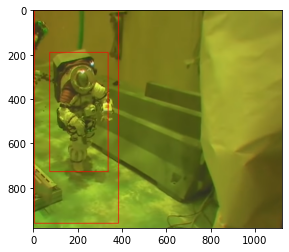

In [89]:
plot_detections(detections,ig_path)